## Import Libraries

In [105]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
from tensorflow import get_logger
get_logger().setLevel("ERROR")

CPU times: total: 31.2 ms
Wall time: 255 ms


In [82]:
from typing import Tuple

import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import random

# ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# model preprocessing & evaluation
from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from prophet import Prophet
from xgboost import XGBRegressor

# Deep learning
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 

In [ ]:
# from tensorflow.keras.backend import clear_session
print(tf.__version__)

2.15.0


In [ ]:
SEED = 1412
random.seed(SEED)
np.random.seed(SEED)
set_seed(SEED)

In [ ]:
sns.set_color_codes(palette="deep")   
sns.set_style(style="whitegrid")

## Data

In [ ]:
dangcem = pd.read_csv("data/dangcem.csv")
# Convert date variable to date data type
dangcem["date"] = pd.to_datetime(dangcem["date"])

dangcem = dangcem.sort_values(by="date").reset_index(drop=True)

dangcem.head()

,date,close,open,high,low,volume,perct_change
0,2013-01-02,128.1,128.1,128.1,128.1,135910.0,0.00
1,2013-01-03,125.0,125.0,125.0,125.0,185160.0,-2.42
2,2013-01-04,125.0,125.0,125.0,125.0,91780.0,0.00
3,2013-01-07,125.0,125.0,125.0,125.0,95320.0,0.00
4,2013-01-08,125.0,125.0,125.0,125.0,115580.0,0.00


## Functions

In [ ]:
def split_train_test_set(X:pd.DataFrame, y:pd.Series, steps:int=365) -> Tuple[pd.DataFrame]:
    """ """
    # all years before the last year(s) (steps)
    X_all_train = X.iloc[:-steps, :]
    y_all_train = y.iloc[:-steps, :]
    # Extract validation set from the train set
    X_train = X_all_train.iloc[:-steps, :]
    y_train = y_all_train.iloc[:-steps, :]
    X_val = X_all_train.iloc[-steps:, :]
    y_val = y_all_train.iloc[-steps:, :]
    # Test set
    X_test  = X.iloc[-steps:, :]
    y_test  = y.iloc[-steps:, :]
    
    return X_all_train, y_all_train, X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
def model_metrics(y_true, y_pred, output_type:str):
    """ """
    MAE  = mean_absolute_error(y_true, y_pred)
    MAPE = mean_absolute_percentage_error(y_true, y_pred)
    MSE  = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(MSE)

    if output_type == "print":
        print(f"Mean Absolute Error: {MAE:.3}")
        print(f"Mean Absolute Percentage Error: {MAPE:.3}")
        print(f"Mean Squared Error: {MSE:.3}")
        print(f"Root Mean Squared Error: {RMSE:.3}")

    elif output_type == "values":
        return MAE, MAPE, RMSE
    else:
        print(f"Mean Absolute Error: {MAE:.3}")
        print(f"Mean Absolute Percentage Error: {MAPE:.3}")
        print(f"Mean Squared Error: {MSE:.3}")
        print(f"Root Mean Squared Error: {RMSE:.3}")

        return MAE, MAPE, RMSE

In [ ]:
def check_stationarity(timeseries): 
	# Perform the Dickey-Fuller test 
	result = adfuller(timeseries, autolag='AIC') 
	p_value = result[1] 
	print(f'ADF Statistic: {result[0]}') 
	print(f'p-value: {p_value}') 
	print('Data is Stationary' if p_value < 0.05 else 'Data is Non-Stationary') 
      
def differencing(data, d=1):
	differenced_data = data - data.shift(d)
	differenced_data = differenced_data.fillna(0.0)
	return differenced_data

## Data Engineering

### Data Split

In [292]:
# Separate features from target variable.
X = dangcem.drop("close", axis=1)
y = dangcem[["close"]]

In [293]:
steps = 365

# all years before the last year(s) (steps)
X_all_train = X.iloc[:-steps, :]
y_all_train = y.iloc[:-steps, :]

all_train_dt = dangcem.iloc[:-steps, :]

# Extract validation set from the train set
X_train = X_all_train.iloc[:-steps, :]
y_train = y_all_train.iloc[:-steps, :]
X_val = X_all_train.iloc[-steps:, :]
y_val = y_all_train.iloc[-steps:, :]

train_dt = all_train_dt.iloc[:-steps, :]
val_dt = all_train_dt.iloc[-steps:, :]

# Test set
X_test = X.iloc[-steps:, :]
y_test = y.iloc[-steps:, :]

test_dt = dangcem.iloc[-steps:, :]

In [295]:
print(f"Train samples: {X_all_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

Train samples: 2356
Test samples: 365


In [ ]:
# set date as index
dangcem_dt = dangcem.set_index("date")

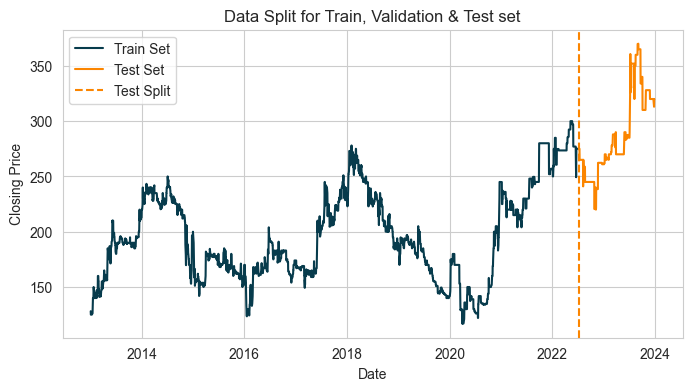

In [299]:
plt.figure(figsize=(8, 4))

plt.plot(X_all_train["date"], y_all_train["close"], color="#073B4C", label="Train Set")
# plt.plot(X_val["date"], y_val["close"], color="#219EBC", label="Validation Set")
plt.plot(X_test["date"], y_test["close"], color="#FB8500", label="Test Set")

# Add vertical lines for the validation name
plt.axvline(x=X_val["date"].max(), color="#FB8500", linestyle="dashed", label="Test Split")

plt.title("Data Split for Train, Validation & Test set")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend()
plt.grid(True)
plt.savefig('images/data_split.png') 
plt.show()

### Normalize price

In [ ]:
# mm_scaler = MinMaxScaler(feature_range=(0, 1))

# mm_scaler.fit()

## Forecast

### ARIMA

In [153]:
all_train_dt = all_train_dt.set_index("date")
train_dt = train_dt.set_index("date")           
val_dt   = val_dt.set_index("date")
test_dt  = test_dt.set_index("date")

# all_train_dt.index = all_train_dt.index.to_period('D')

In [ ]:
check_stationarity(differencing(all_train_dt['close']))

ADF Statistic: -48.48236961586386
p-value: 0.0
Data is Stationary


In [ ]:
diff_all_train_dt = differencing(all_train_dt['close'])

<Figure size 800x400 with 0 Axes>

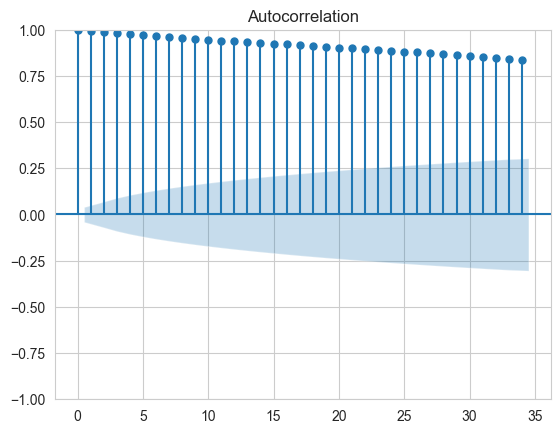

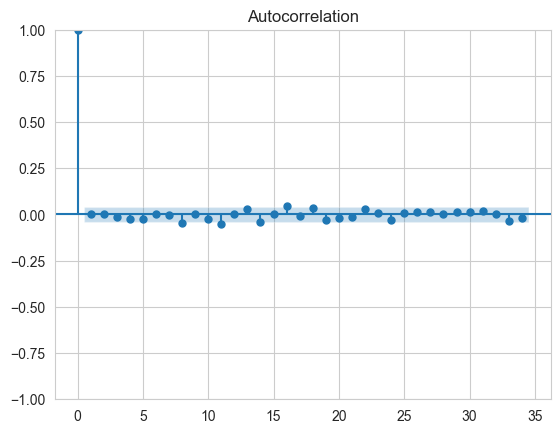

In [ ]:
fig = plt.figure(figsize=(8, 4))

plot_acf(all_train_dt['close'])
plot_acf(diff_all_train_dt)

plt.show()

<Figure size 800x400 with 0 Axes>

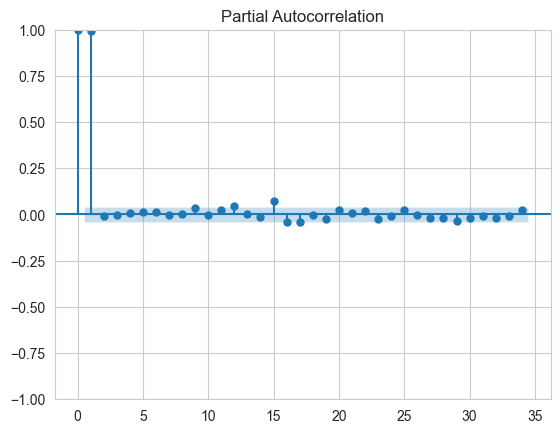

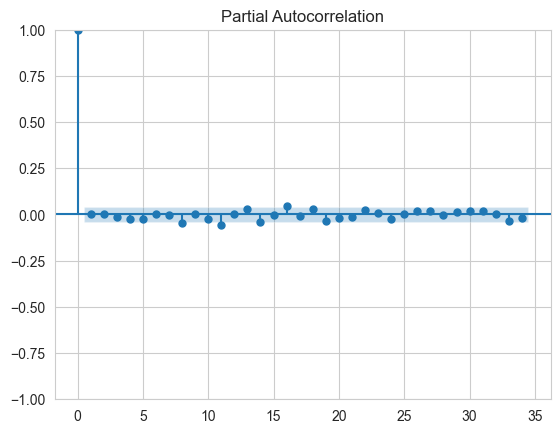

In [ ]:
fig = plt.figure(figsize=(8, 4))

plot_pacf(all_train_dt['close'])
plot_pacf(diff_all_train_dt)

plt.show()

In [171]:
# Auto arima to determine ARIMA orders

stepwise_fit = auto_arima(
    all_train_dt["close"],
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    m=12,
    start_P=0,
    seasonal=False,
    d=1, D=0, 
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13129.745, Time=0.67 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13125.746, Time=0.21 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13127.745, Time=0.54 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13127.745, Time=0.46 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13124.341, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.076 seconds


In [174]:
print(stepwise_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2356
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6561.170
Date:                Fri, 28 Jun 2024   AIC                          13124.341
Time:                        01:48:45   BIC                          13130.105
Sample:                             0   HQIC                         13126.440
                               - 2356                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        15.3986      0.195     78.790      0.000      15.016      15.782
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              7171.43
Prob(Q):                              0.98   Pr

In [172]:
# Define ARIMA model instance
arima_model = ARIMA(all_train_dt["close"], order=(0, 1, 0))

# Fit ARIMA model
arima_model_fit = arima_model.fit()

In [173]:
# Forecast new prices with the length of the test dataset
arima_prediction = arima_model_fit.forecast(len(test_dt))
# Collect metrics
arima_MAE, arima_MAPE, arima_RMSE = model_metrics(test_dt["close"], arima_prediction, "all")

Mean Absolute Error: 30.9
Mean Absolute Percentage Error: 0.101
Mean Squared Error: 1.63e+03
Root Mean Squared Error: 40.4


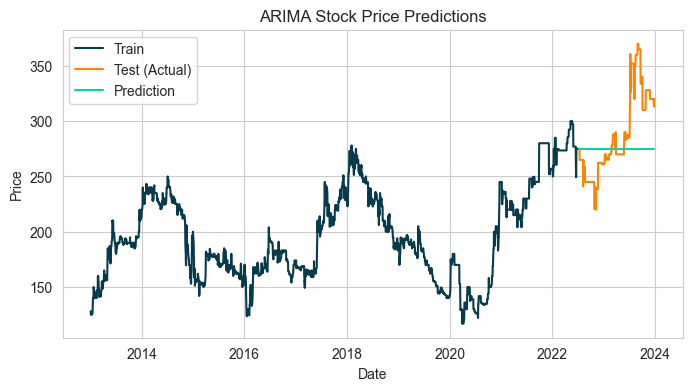

In [176]:
plt.figure(figsize=(8, 4))
plt.plot(all_train_dt.index, all_train_dt["close"], label="Train", color="#073B4C")
plt.plot(test_dt.index, test_dt["close"], label="Test (Actual)", color="#FB8500")
plt.plot(test_dt.index, arima_prediction, label="Prediction", color="#06D6A0")

plt.title("ARIMA Stock Price Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

plt.savefig('images/arima_pred.png') 
plt.show()

### Prophet

In [178]:
# Prepare Data

# Select needed veriables
fb_train = all_train_dt.reset_index()[["date", "close"]]
fb_test = test_dt.reset_index()[["date", "close"]]

# Rename columns based on prophet API
fb_train = fb_train.rename(columns={"date": "ds", "close": "y"})
fb_test = fb_test.rename(columns={"date": "ds", "close": "y"})

In [215]:
# Create Prophet model instance
p_model = Prophet(changepoint_prior_scale=0.01)

# Fit the model 
p_model.fit(fb_train)

02:58:34 - cmdstanpy - INFO - Chain [1] start processing
02:58:35 - cmdstanpy - INFO - Chain [1] done processing


In [216]:
# Create new dates of 356 days
new_df = dangcem[["date"]].rename(columns={"date": "ds"})

# make prediction
p_forecast = p_model.predict(new_df)

In [217]:
p_forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,155.921100,136.049289,185.821356,155.921100,155.921100,4.750094,4.750094,4.750094,5.548970,5.548970,5.548970,-0.798876,-0.798876,-0.798876,0.0,0.0,0.0,160.671194
1,2013-01-03,156.033185,135.976174,185.053249,156.033185,156.033185,5.029717,5.029717,5.029717,5.785434,5.785434,5.785434,-0.755717,-0.755717,-0.755717,0.0,0.0,0.0,161.062902
2,2013-01-04,156.145269,135.248273,185.444925,156.145269,156.145269,4.778311,4.778311,4.778311,5.491583,5.491583,5.491583,-0.713272,-0.713272,-0.713272,0.0,0.0,0.0,160.923580


In [218]:
# Separate Train predictions from test
p_test_forecast = p_forecast[p_forecast['ds'].isin(fb_test['ds'])]
p_train_forecast = p_forecast[~p_forecast['ds'].isin(fb_test['ds'])]

In [219]:
# Collect prophet metrics
p_MAE, p_MAPE, p_RMSE = model_metrics(fb_test["y"], p_test_forecast["yhat"], "all")

Mean Absolute Error: 71.2
Mean Absolute Percentage Error: 0.256
Mean Squared Error: 5.48e+03
Root Mean Squared Error: 74.0


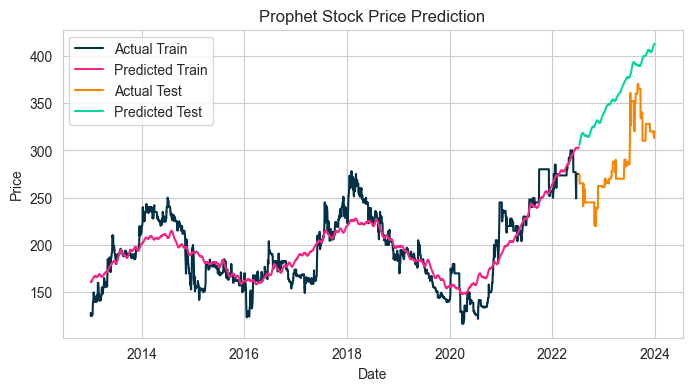

In [220]:
plt.figure(figsize=(8, 4))
plt.plot(fb_train["ds"], fb_train["y"], label="Actual Train", color="#023047")
plt.plot(p_train_forecast["ds"], p_train_forecast["yhat"], label="Predicted Train", color="#F72585")
plt.plot(fb_test["ds"], fb_test["y"], label="Actual Test", color="#FB8500")
plt.plot(p_test_forecast["ds"], p_test_forecast["yhat"], label="Predicted Test", color="#06D6A0")

plt.title("Prophet Stock Price Prediction")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()

plt.savefig('images/prophet_pred.png') 
plt.show()

### LSTM

In [ ]:
# Create model callback values including early stopping setting and LR reducer
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.8, patience=10, min_lr=1e-5)
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

In [ ]:
rn_dangcem = dangcem[["date", "close"]]

In [231]:
# Split data into train and test set
split_date = "2022-01-01"

rn_train = rn_dangcem.loc[rn_dangcem["date"] < split_date]
rn_test  = rn_dangcem.loc[rn_dangcem["date"] >= split_date]

rn_train = rn_train.set_index('date')
rn_test = rn_test.set_index('date')

rn_dangcem = rn_dangcem.set_index("date")

In [ ]:
# Normalize the data
mm_scaler = MinMaxScaler(feature_range=(0, 1))

scaled_rn_train = mm_scaler.fit_transform(rn_train)
scaled_rn_test = mm_scaler.transform(rn_test)

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
        
    return np.array(X), np.array(y)

In [ ]:
# Set initial empty lags(sequence length) and mae lists
lags, mae = [], []
# Train using 10 to 19 time steps
for sl in range(10, 21):

    X, y = create_sequences(scaled_rn_train, sl)

    # Split the data into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    # Reshape input to be [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
        
    # Build the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, return_sequences=True, input_shape=(sl, 1)))
    lstm_model.add(LSTM(50, return_sequences=False))
    lstm_model.add(Dense(25))
    lstm_model.add(Dense(1))

    lstm_model.compile(loss="mean_squared_error", optimizer=Adam(learning_rate=0.001), metrics="mae")

    history = lstm_model.fit(
        X_train, y_train, 
        validation_data=(X_val, y_val), 
        epochs=100, 
        batch_size=32,
        verbose=0,
        callbacks=[reduce_lr, early_stopping]
    )

    # Get the inverse (min-max transformed) sunspot values
    mdl_mae = np.array(history.history["val_mae"][-1]).reshape(1, -1)
    mae_inv = mm_scaler.inverse_transform(mdl_mae)

    # Append to lags and mae list
    lags.append(sl)
    mae.append(mae_inv[0, 0])
    # print current time step MAE value
    print(f"Lags: {sl} || MAE: {mae_inv[0,0]}")

Lags: 10 || MAE: 118.96071134507656
Lags: 11 || MAE: 119.37407034039498
Lags: 12 || MAE: 119.0141176313162
Lags: 13 || MAE: 118.97848770320417
Lags: 14 || MAE: 119.03315977752209
Lags: 15 || MAE: 118.85171039402485
Lags: 16 || MAE: 119.14648869633675
Lags: 17 || MAE: 118.99827430546284
Lags: 18 || MAE: 119.60425317287445
Lags: 19 || MAE: 119.69067208766938
Lags: 20 || MAE: 118.99912819564344


In [ ]:
# Convert to pandas data frame and sort by each time step mean absolute error soreted from small to large
pd.DataFrame({"Lags": lags, "MAE": mae}).sort_values(by="MAE", ascending=True)

,Lags,MAE
5,15,118.851710
0,10,118.960711
3,13,118.978488
7,17,118.998274
10,20,118.999128
2,12,119.014118
4,14,119.033160
6,16,119.146489
1,11,119.374070
8,18,119.604253


In [ ]:
sl = 15

In [269]:
X, y = create_sequences(scaled_rn_train, sl)
X_test, y_test = create_sequences(scaled_rn_test, sl)

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_all_train = np.reshape(X, (X.shape[0], X.shape[1], 1))
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# Build the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(sl, 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

lstm_model.compile(
    loss="mean_squared_error", 
    optimizer=Adam(learning_rate=0.001), 
    metrics=["mean_absolute_error", "mean_squared_error"]
)

lstm_history = lstm_model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=100, 
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
56/56 [==============================] - 26s 120ms/step - loss: 0.0147 - mean_absolute_error: 0.0830 - mean_squared_error: 0.0147 - val_loss: 0.0053 - val_mean_absolute_error: 0.0550 - val_mean_squared_error: 0.0053 - lr: 0.0010
Epoch 2/100
56/56 [==============================] - 2s 39ms/step - loss: 0.0024 - mean_absolute_error: 0.0344 - mean_squared_error: 0.0024 - val_loss: 0.0036 - val_mean_absolute_error: 0.0410 - val_mean_squared_error: 0.0036 - lr: 0.0010
Epoch 3/100
56/56 [==============================] - 2s 36ms/step - loss: 0.0022 - mean_absolute_error: 0.0319 - mean_squared_error: 0.0022 - val_loss: 0.0037 - val_mean_absolute_error: 0.0421 - val_mean_squared_error: 0.0037 - lr: 0.0010
Epoch 4/100
56/56 [==============================] - 2s 35ms/step - loss: 0.0021 - mean_absolute_error: 0.0315 - mean_squared_error: 0.0021 - val_loss: 0.0035 - val_mean_absolute_error: 0.0438 - val_mean_squared_error: 0.0035 - lr: 0.0010
Epoch 5/100
56/56 [=======================

In [ ]:
temp = pd.DataFrame(lstm_history.history)
temp.head()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,lr
0,0.014676,0.082955,0.014676,0.005276,0.055035,0.005276,0.001
1,0.002405,0.034440,0.002405,0.003645,0.041035,0.003645,0.001
2,0.002199,0.031894,0.002199,0.003704,0.042073,0.003704,0.001
3,0.002125,0.031539,0.002125,0.003503,0.043801,0.003503,0.001
4,0.002350,0.035053,0.002350,0.003342,0.040867,0.003342,0.001


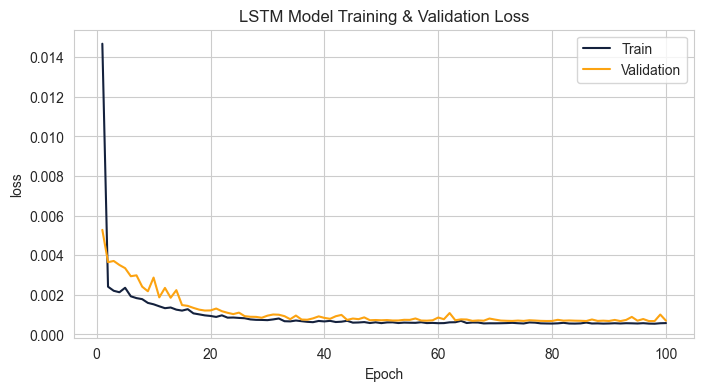

In [224]:
fig = plt.figure(figsize=(8, 4))
plt.plot(list(range(1, len(temp)+1)), temp["loss"], label="Train", color="#14213D")
plt.plot(list(range(1, len(temp)+1)), temp["val_loss"], label="Validation", color="#FCA311")
plt.title("LSTM Model Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()

plt.savefig('images/lstm_loss.png') 
plt.show()

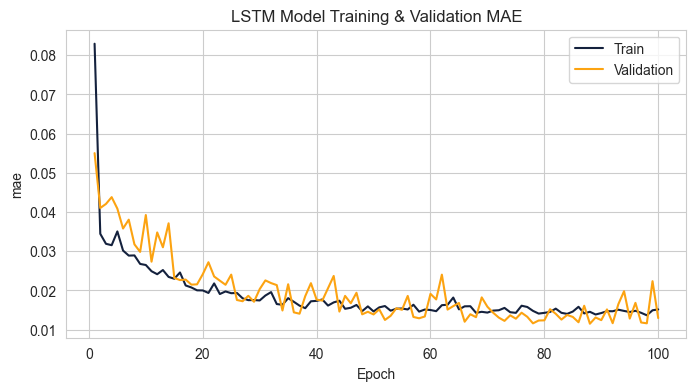

In [225]:
fig = plt.figure(figsize=(8, 4))
plt.plot(list(range(1, len(temp)+1)), temp["mean_absolute_error"], label="Train", color="#14213D")
plt.plot(list(range(1, len(temp)+1)), temp["val_mean_absolute_error"], label="Validation", color="#FCA311")
plt.title("LSTM Model Training & Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("mae")
plt.legend()

plt.savefig('images/lstm_mae.png') 
plt.show()

In [ ]:
# Make predictions
lstm_train_predict = lstm_model.predict(X_all_train)
lstm_test_predict = lstm_model.predict(X_test)

15/15 [==============================] - 1s 16ms/step


In [ ]:
# Invert predictions to original scale
lstm_train_predict = mm_scaler.inverse_transform(lstm_train_predict)
y_train_inv = mm_scaler.inverse_transform([y])
lstm_test_predict = mm_scaler.inverse_transform(lstm_test_predict)
y_test_inv = mm_scaler.inverse_transform([y_test])

In [ ]:
# Calculate RMSE
lstm_train_rmse = np.sqrt(mean_squared_error(y_train_inv[0], lstm_train_predict[:,0]))
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_inv[0], lstm_test_predict[:,0]))
print(f'Train RMSE: {lstm_train_rmse}')
print(f'Test RMSE: {lstm_test_rmse}')

Train RMSE: 3.8659626822185684
Test RMSE: 5.875113035348203


In [ ]:
lstm_MAE, lstm_MAPE, lstm_RMSE = model_metrics(y_test_inv[0], lstm_test_predict[:,0], "all")

Mean Absolute Error: 2.74
Mean Absolute Percentage Error: 0.00935
Mean Squared Error: 34.5
Root Mean Squared Error: 5.88


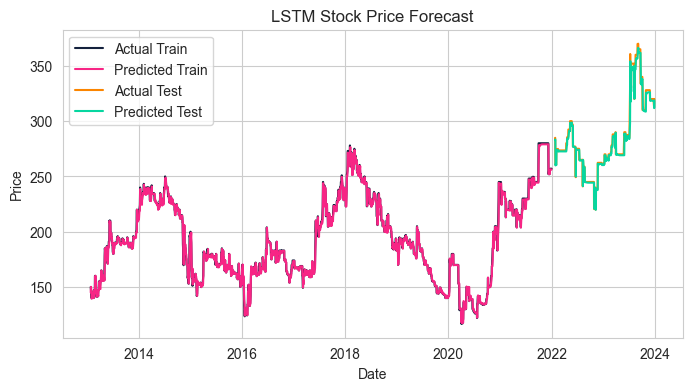

In [271]:
# Plot results
plt.figure(figsize=(8, 4))
plt.plot(rn_dangcem.index[sl:len(X_all_train)+sl], y_train_inv[0], label='Actual Train', color="#14213D")
plt.plot(rn_dangcem.index[sl:len(X_all_train)+sl], lstm_train_predict[:,0], label='Predicted Train', color="#F72585")
plt.plot(rn_dangcem.index[-len(X_test):], y_test_inv[0], label='Actual Test', color="#FB8500")
plt.plot(rn_dangcem.index[-len(X_test):], lstm_test_predict[:,0], label='Predicted Test', color="#06D6A0")
plt.title('LSTM Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.savefig('images/lstm_stock_pred.png')
plt.show()

In [92]:
# Save Model entire architecture and weights
lstm_model.save("model/stock_lstm.h5")

In [ ]:
# # Function for making future predictions
# def predict_future(model, last_sequence, steps):
#     future_predict = []
#     current_sequence = last_sequence.reshape((1, sl, 1))
    
#     for _ in range(steps):
#         current_pred = model.predict(current_sequence)[0]
#         future_predict.append(current_pred)
#         current_sequence = np.roll(current_sequence, -1, axis=1)
#         current_sequence[0, -1, 0] = current_pred
    
#     return np.array(future_predict)

# # Make short-term and long-term predictions
# last_sequence = X_test[-1]
# short_term_forecast = predict_future(lstm_model, last_sequence, 30)  # 30 days
# long_term_forecast = predict_future(lstm_model, last_sequence, 365)  # 365 days

# # Inverse transform predictions
# short_term_forecast = scaler.inverse_transform(short_term_forecast)
# long_term_forecast = scaler.inverse_transform(long_term_forecast)

# print("\nShort-term forecast (next 30 days):")
# print(short_term_forecast)

# print("\nLong-term forecast (next 365 days):")
# print(long_term_forecast)

### XGBoost

In [256]:
xg_dangcem = dangcem[["date", "close"]]
xg_dangcem = xg_dangcem.set_index('date')

In [257]:
# Create lagged features
def create_features(df, label=None, lags=[1, 7, 30]):
    df_new = df.copy()
    
    for lag in lags:
        df_new[f'lag_{lag}'] = df_new['close'].shift(lag)
    
    # Add day of week and month as features
    df_new['day_of_week'] = df_new.index.dayofweek
    df_new['month'] = df_new.index.month
    
    if label:
        df_new['label'] = df_new[label].shift(-1)
        df_new = df_new.dropna()
    
    return df_new


xg_features = create_features(xg_dangcem, label='close')

In [258]:
# Split the data into training and testing sets
split_date = "2023-01-01"
train_data = xg_features[:split_date]
test_data = xg_features[split_date:]

# Prepare the features and labels
features = ['lag_1', 'lag_7', 'lag_30', 'day_of_week', 'month']
X_train, y_train = train_data[features], train_data['label']
X_test, y_test = test_data[features], test_data['label']

In [259]:
# Scale the features
mm_scaler = MinMaxScaler()

X_train_scaled = mm_scaler.fit_transform(X_train)
X_test_scaled = mm_scaler.transform(X_test)

In [260]:
# Create xgb tune parameter grid
xgb_params = {
    "n_estimators": [100, 300, 500, 1000],
    "learning_rate": [0.01, 0.1, 0.2],
    "gamma": [0, 0.1, 0.2],
    "max_depth": [3, 5, 7, 9]
}

xbg_gs = GridSearchCV(XGBRegressor(), xgb_params, cv=5, n_jobs=-1, scoring="neg_mean_absolute_error")
xbg_gs.fit(X_train_scaled, y_train)

print(f"Best Params {xbg_gs.best_params_}")

Best Params {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}


In [261]:
print(f"Mean Absolute Error: {-xbg_gs.best_score_}")

Mean Absolute Error: 5.039761762186062


In [262]:
# Create and train the XGBoost model with best parameters
xgb_model = XGBRegressor(**xbg_gs.best_params_)

xgb_model.fit(X_train_scaled, y_train)

# Make predictions
xgb_train_predictions = xgb_model.predict(X_train_scaled)
xgb_test_predictions = xgb_model.predict(X_test_scaled)

In [263]:
_, _, _ = model_metrics(y_train, xgb_train_predictions, "all")

Mean Absolute Error: 3.34
Mean Absolute Percentage Error: 0.0173
Mean Squared Error: 27.8
Root Mean Squared Error: 5.28


In [264]:
xgb_MAE, xgb_MAPE, xgb_RMSE = model_metrics(y_test, xgb_test_predictions, "all")

Mean Absolute Error: 23.6
Mean Absolute Percentage Error: 0.0702
Mean Squared Error: 1.11e+03
Root Mean Squared Error: 33.4


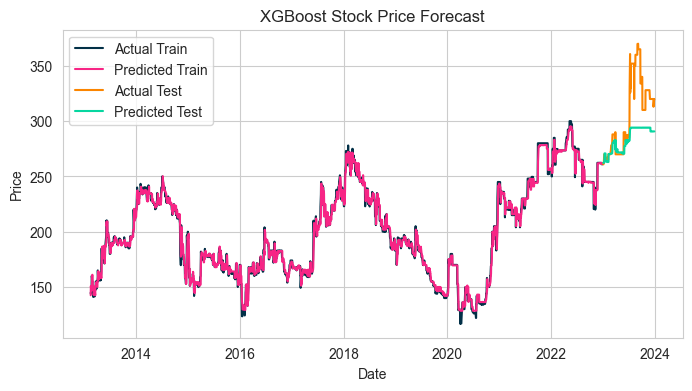

In [267]:
# Plot results
plt.figure(figsize=(8, 4))

plt.plot(train_data.index, y_train, label='Actual Train', color="#023047")
plt.plot(train_data.index, xgb_train_predictions, label='Predicted Train', color="#F72585")
plt.plot(test_data.index, y_test, label='Actual Test', color="#FB8500")
plt.plot(test_data.index, xgb_test_predictions, label='Predicted Test', color="#06D6A0")
plt.title('XGBoost Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.savefig('images/xgb_pred.png') 
plt.show()

In [ ]:
# Function for making future predictions
# def predict_future(model, last_known_prices, steps, scaler):
#     future_prices = []

#     current_features = last_known_prices[-30:].tolist()  # Using `lag_30`` as max lag
    
#     for _ in range(steps):
#         # Prepare features for prediction # day_of_week and month
#         X = [current_features[-1], current_features[-7], current_features[-30], (_ + 1) % 7, (_ // 30 + 1) % 12 + 1]  
#         X_scaled = mm_scaler.transform([X])
        
#         # Make prediction
#         prediction = model.predict(X_scaled)[0]
#         future_prices.append(prediction)
        
#         # Update features for next prediction
#         current_features.append(prediction)
    
#     return future_prices



# # Make short-term and long-term predictions
# last_known_prices = dangcem['price'].values
# short_term_forecast = predict_future(xgb_model, last_known_prices, 30, scaler)
# long_term_forecast = predict_future(xgb_model, last_known_prices, 365, scaler)

# print("\nShort-term forecast (next 30 days):")
# print(short_term_forecast)

# print("\nLong-term forecast (next 365 days):")
# print(long_term_forecast)

# # Plot feature importances
# plt.figure(figsize=(10, 6))
# xgb.plot_importance(model)
# plt.title('Feature Importances')
# plt.show()

## Evaluation

In [287]:
eval_df = pd.DataFrame({
    "model": ["ARIMA", "Prophet", "LSTM", "XGBoost"],
    "MAE": [arima_MAE, p_MAE, lstm_MAE, xgb_MAE],
    "MAPE": [arima_MAPE, p_MAPE, lstm_MAPE, xgb_MAPE],
    "RMSE": [arima_RMSE, p_RMSE, lstm_RMSE, xgb_RMSE]
})

eval_df

,model,MAE,MAPE,RMSE
0,ARIMA,30.921644,0.101269,40.431854
1,Prophet,71.224313,0.256143,74.005439
2,LSTM,2.735750,0.009347,5.875113
3,XGBoost,23.633100,0.070217,33.360157


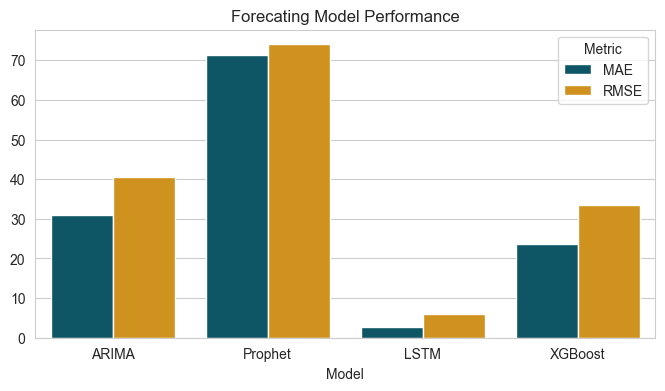

In [290]:
plt.figure(figsize=(8, 4))
sns.barplot(
    x="model", y="value",
    data=eval_df.melt(id_vars="model", value_vars=["MAE", "RMSE"], var_name="Metric"),
    hue="Metric",
    palette=["#005F73", "#EE9B00"]
)

plt.title("Forecating Model Performance")
plt.xlabel("Model")
plt.ylabel("")

plt.savefig('images/model_eval.png') 
plt.show()